**Clothes Replacement Case Study combining a Segmentation and a Difussion generative model**

**By Javier ideami / ideami.com**

This project combines Segmentation, Image Editing and Generation

Using Segment Anything from Meta AI for Segmentation (Apache Licence 2.0)
requirements: an image

Using Stable Diffusion for InPainting 
requirements: an image + a mask + a text prompt

Using GPT to generate visualization function (optional, requires OpenAI API)

# **Installing libraries**

**regex**: Advanced regular expressions library for searching and manipulating text.

**tqdm**: Fast, extensible progress bar for loops and iterable objects.

**diffusers by Hugging Face:**: Diffusers provides pretrained vision and audio diffusion models, and serves as a modular toolbox for inference and training

**transformers by Hugging Face:**: Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.

**scipy**: Scientific computing library for optimization, integration, and other mathematical operations.

**accelerate by Hugging Face**: In short, training and inference at scale made simple, efficient and adaptable

**Xformers**: Optimizes transformers architecture. Toolbox to Accelerate Research on Transformers

**opencv**: OpenCV is a library of programming functions mainly for real-time computer vision


In [1]:
### General Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy 
!pip install -q -U xformers
!pip install -q opencv-python


In [2]:
### Sam libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

In [3]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor



**Download Segment Anything Checkpoint**

Download the checkpoint file called **sam_vit_h_4b8939.pth**
and put it on the same folder where your notebook is

**Current Download link:**
https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
(if it doesn't work, it may have moved somewhere else, check instructions at https://github.com/facebookresearch/segment-anything )

In [ ]:
### Downloading checkpoint file to same folder where the notebook is
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [4]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems 


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\Usuario\miniconda3\envs\voiceAI\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Source image size: (3923, 5811)
Target image size: (512, 512)


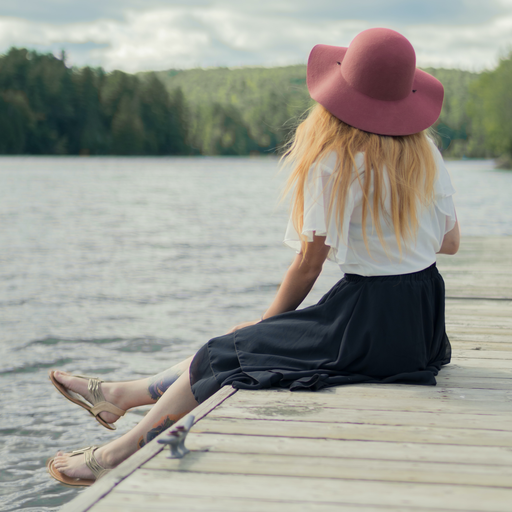

In [5]:
### Example image from unsplash.com
### Photo by Lac McGregor, Canada
### Free to use under the Unsplash License
### Link: https://unsplash.com/photos/AsJirOOLN_s

### IMPORTANT: Upload the unsplash image inside the same folder where the notebook is

target_width, target_height = 512,512 # if you have memory issues, reduce even more the target size
source_image = Image.open('mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")

# We make the image square
source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# We resize the image to the target dimensions (so that it uses less memory)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

### we convert the image into an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)

display(source_image)



In [6]:
### Initialize Segment Anything Model

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

### Pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher to generate masks only of 
### good quality and less number of them
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


In [7]:
### Run Segmentation Model
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes. 
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region


Number of masks generated: 10
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [8]:
### Declare function to visualize the masks generated together with a number that identifies each of them

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')



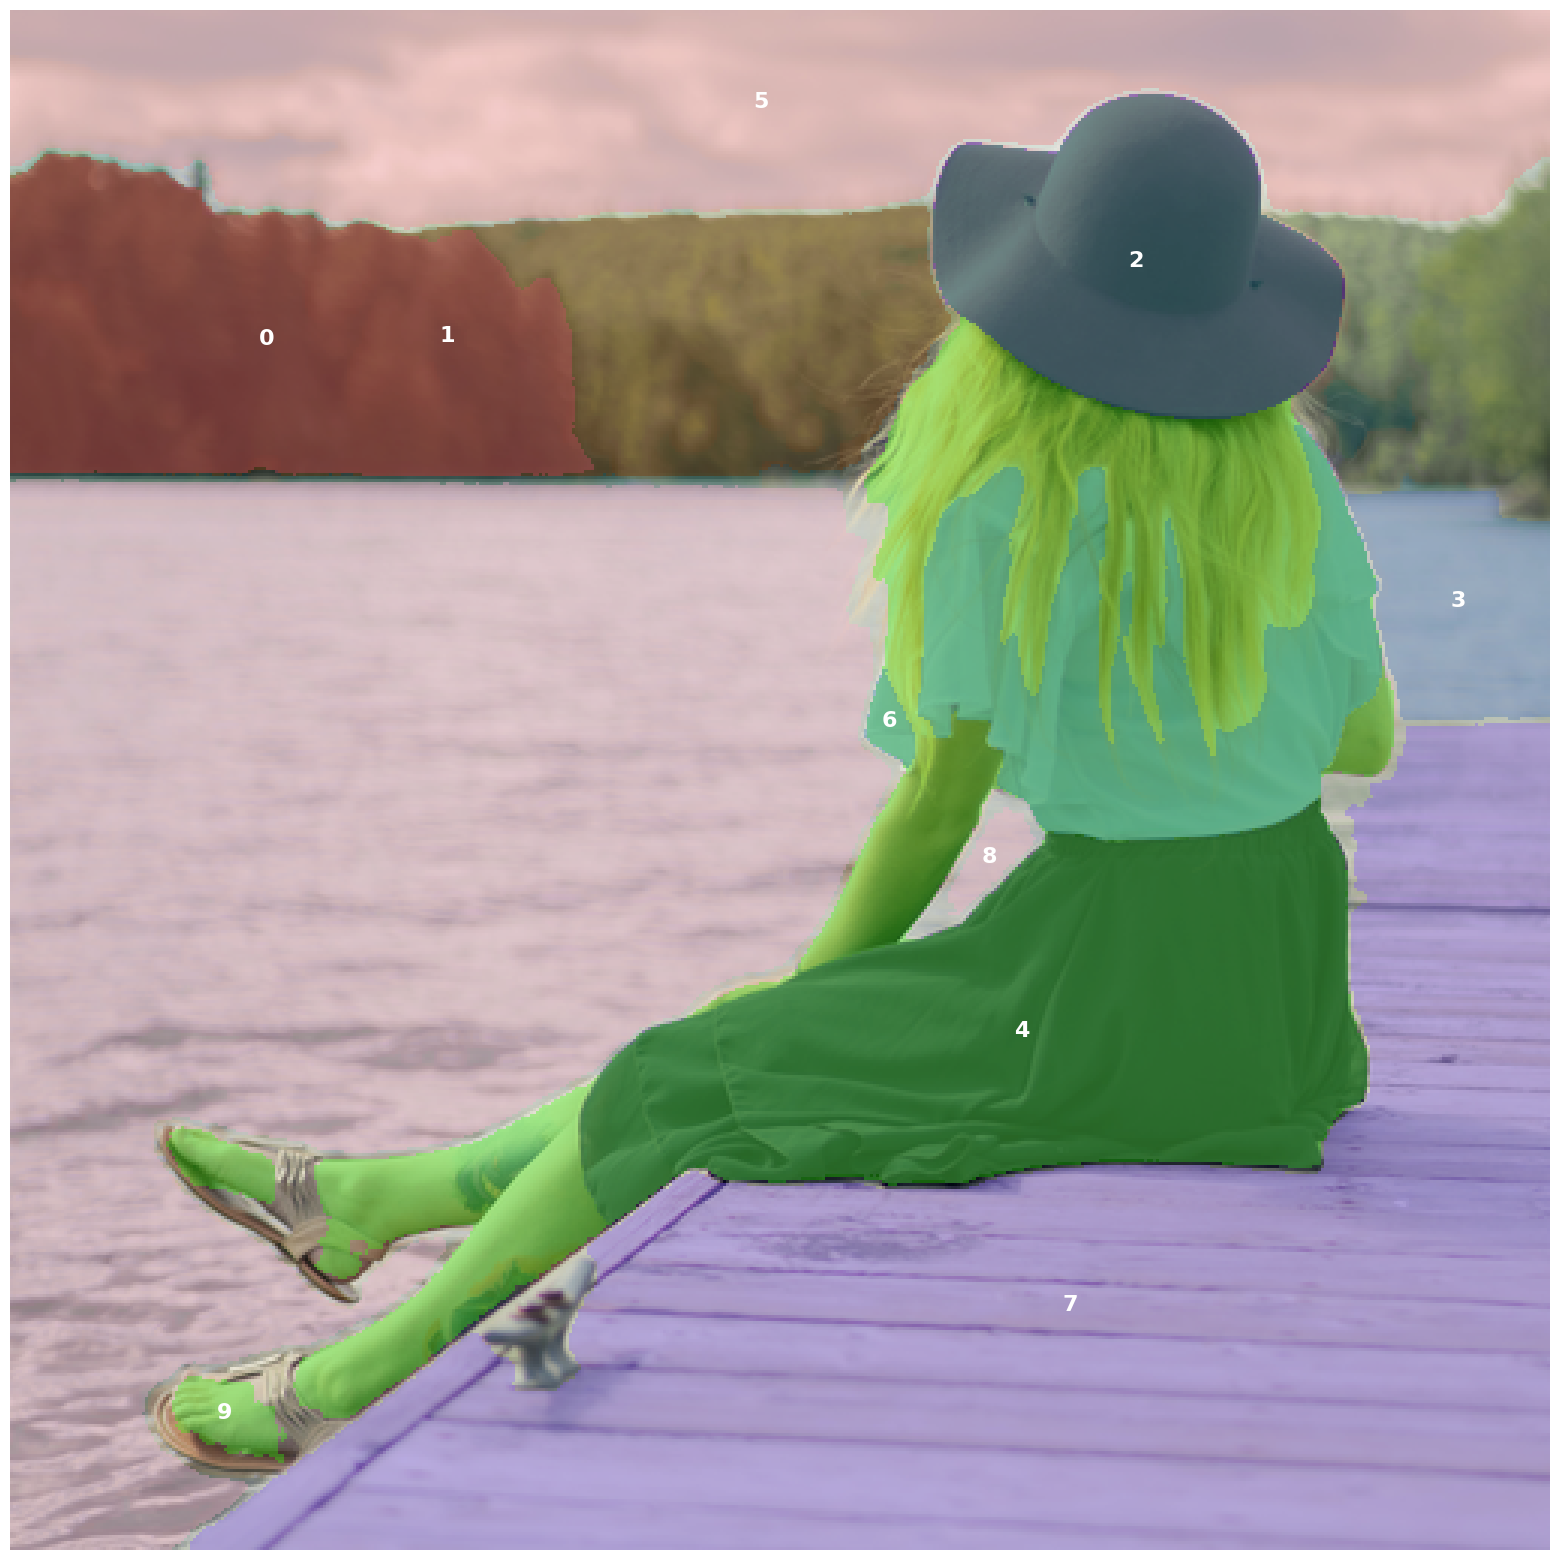

In [9]:
### Display Masks with a number identifying each of them

plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show() 

In [10]:
### Explore one of the keys of the mask
for i, values in enumerate(masks):
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")

# IoU: 0 means no overlap and 1 means perfect overlap


0: Area: 16233 | IoU: 1.0126675367355347
1: Area: 26659 | IoU: 0.9977993965148926
2: Area: 10622 | IoU: 1.0191762447357178
3: Area: 4174 | IoU: 0.9900398850440979
4: Area: 21804 | IoU: 1.0157097578048706
5: Area: 29795 | IoU: 1.008736491203308
6: Area: 10455 | IoU: 0.9937481880187988
7: Area: 54709 | IoU: 1.041186809539795
8: Area: 66861 | IoU: 1.014755129814148
9: Area: 63180 | IoU: 1.009932279586792


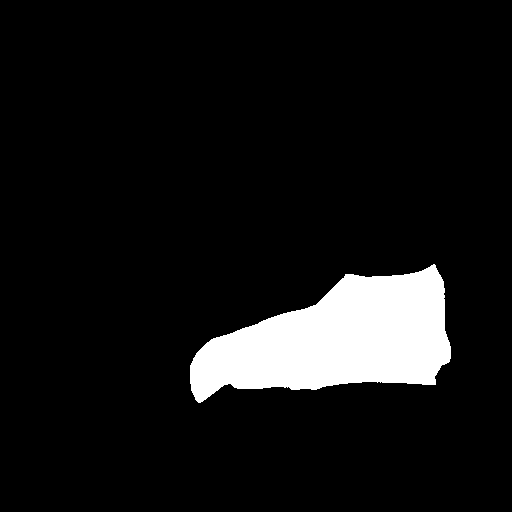

In [11]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 4
mask_index = 4

segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [37]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["a skirt full of text",  "red flowers", "blue flowers", "a zebra skirt"]

generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77, 

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

### GPT4
### Prompt:

Give me the python code of a function that takes as arguments:
a) a list of images in Pillow format
b) a list of names of images
c) number of rows
d) number of columns
The function should output a grid of rows x columns displaying the images and with their name below each one

During a back and forth, I also asked it to add comments within the function explaining how it works and also to avoid using systems that require font installation, using instead the simplest possible way that works with google colab. The more details we give, the better

In [36]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


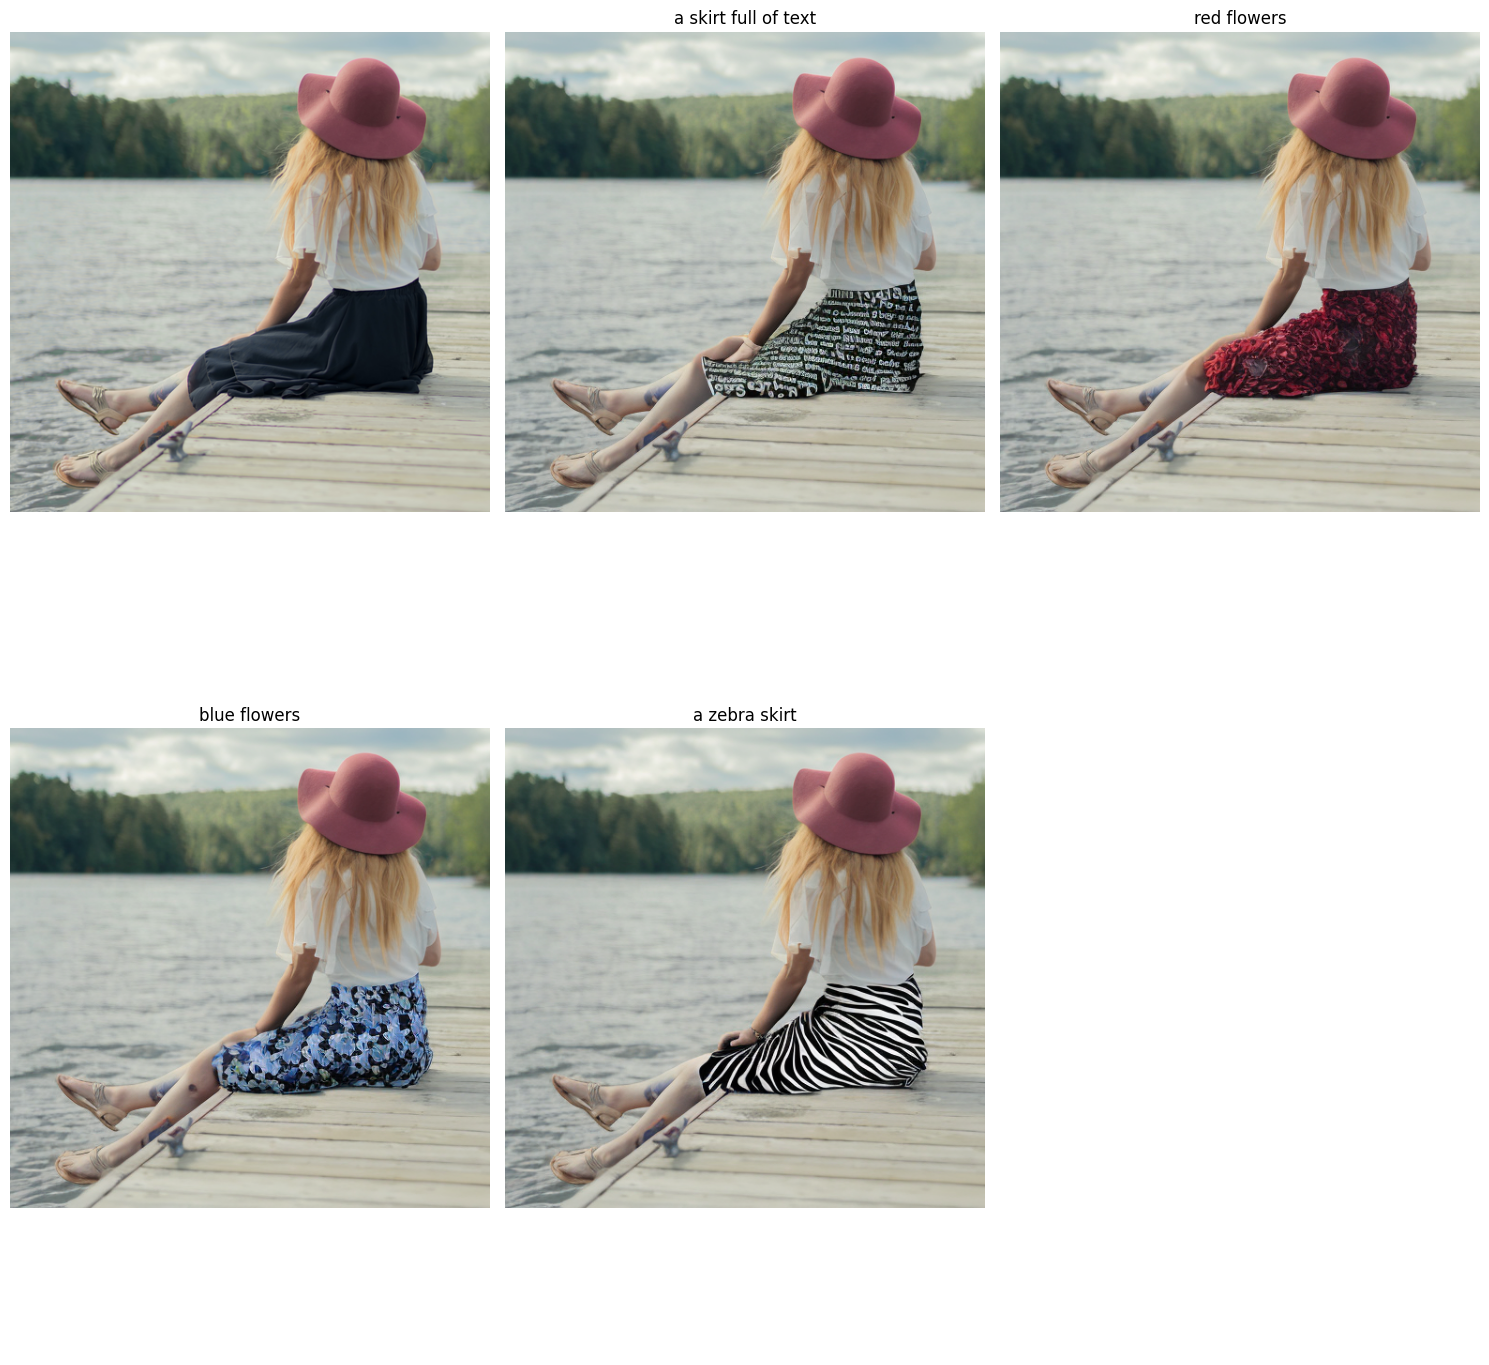

In [40]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)